## Environment Setup

In [ ]:
!pip install torch==2.4.1 transformers==4.45.1 bitsandbytes==0.44.1 peft==0.13.0 datasets

## Mount Your Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
google_drive_path = "/content/drive/MyDrive"
data_path = f"{google_drive_path}/ADL/hw3/data"
train_path = f"{data_path}/train.json"
public_test_path = f"{data_path}/public_test.json"
private_test_path = f"{data_path}/private_test.json"

## Real Training Session

In [3]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, get_scheduler
from transformers import TrainingArguments, Trainer, BitsAndBytesConfig
from peft import LoraConfig, PeftModel
from datasets import load_dataset
import matplotlib.pyplot as plt
import json
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig

In [4]:
# Load dataset
train_data = load_dataset('json', data_files=train_path)["train"]
public_test_data = load_dataset('json', data_files=public_test_path)["train"]
private_test_data = load_dataset('json', data_files=private_test_path)["train"]
print(train_data[0])
print(public_test_data[0])
print(private_test_data[0])

{'id': 'db63fb72-e211-4596-94a4-69617706f7ef', 'instruction': '翻譯成文言文：\n雅裏惱怒地說： 從前在福山田獵時，你誣陷獵官，現在又說這種話。\n答案：', 'output': '雅裏怒曰： 昔畋於福山，卿誣獵官，今復有此言。'}
{'id': '2fb7d211-978f-41c8-a3ab-e51d9df06280', 'instruction': '翻譯成文言文：\n於是，廢帝讓瀋慶之的堂侄、直將軍瀋攸之賜瀋慶之毒藥，命瀋慶之自殺。', 'output': '帝乃使慶之從父兄子直閣將軍攸之賜慶之藥。'}
{'id': 'd573ddd1-7bb9-468d-b906-e392223d9579', 'instruction': '穿右穴而進，其下甚削，陷峽頗深，即下穿所入之峽也，以壁削路阻，不得達。\n幫我把這句話翻譯成現代文'}


In [5]:
def get_bnb_config() -> BitsAndBytesConfig:
    """
    Returns the BitsAndBytes configuration for model quantization.
    """
    nf4_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfaloat16
    )
    return nf4_config

In [7]:
# Tokenizer and model setup
model_name = "zake7749/gemma-2-2b-it-chinese-kyara-dpo"

# Load tokenizer and model from local files if available
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Get BitsAndBytes configuration
bnb_config = get_bnb_config()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# Find max length of text in training set
max_length = 0
for item in train_data:
    length = max(len(item['instruction']), len(item['output']))
    if length > max_length:
        max_length = length

print(f"Max length of text in the training set: {max_length}")

Max length of text in the training set: 326


In [9]:
def get_prompt(instruction: str) -> str:
    '''Format the instruction as a prompt for LLM.'''
    return f"請你扮演一個人工智慧國文助理，幫助用戶在白話文和文言文之間轉換，USER: {instruction} ASSISTANT:"

In [10]:
class TranslationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=2048):
        # self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.data_size = len(data)
        self.instructions = [get_prompt(x["instruction"]) for x in data]
        self.outputs = [x["output"] for x in data]

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        # Tokenize data
        tokenized_instruction = self.tokenizer(
            self.instructions[idx],
            add_special_tokens=False,
        )
        tokenized_output = self.tokenizer(
            self.outputs[idx],
            add_special_tokens=False,
        )

        instruction_input_ids = [self.tokenizer.bos_token_id] + tokenized_instruction["input_ids"]
        output_input_ids = tokenized_output["input_ids"] + [self.tokenizer.eos_token_id]

        input_ids = instruction_input_ids + output_input_ids
        attention_mask = [1] * len(input_ids)
        labels = [-100] * len(instruction_input_ids) + output_input_ids

        input_ids = torch.tensor(input_ids[:self.max_length])
        attention_mask = torch.tensor(attention_mask[:self.max_length])
        labels = torch.tensor(labels[:self.max_length])

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
        }

train_dataset = TranslationDataset(train_data, tokenizer)
public_test_dataset = TranslationDataset(public_test_data, tokenizer)

In [11]:
train_dataset[0]

{'input_ids': tensor([     2, 237261, 235608, 129451,  25367,  77616,  68631, 236321, 235642,
         141771, 235365, 114186, 218253, 235473, 235889, 235997, 235642, 235581,
         235642, 235904, 235642,  98272, 238000, 237022, 235365,  14053, 235292,
          94335, 239790, 235636, 235642, 235904, 235642, 235465,    108, 237363,
         237568, 242365, 237861, 235597, 236478, 235465, 184433, 235648, 235473,
         236421, 112948, 242051, 235716, 235365, 235608, 246747, 238742, 242051,
         236538, 235365,  21017, 236111, 236478,  64785, 235997, 235362,    108,
          48310, 235465, 193541, 235292, 237363, 237568, 237861, 239249, 235465,
         235248, 238505, 252830, 236434, 236421, 235822, 235365, 239284, 246747,
         242051, 236538, 235365, 235811, 237417, 235461, 235966, 235904, 235362,
              1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
from torch.utils.data import DataLoader, Subset
from transformers import DataCollatorForSeq2Seq
import random
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

batch_size = 4
# DataLoader setup
# Set the random seed for reproducibility (optional)
random.seed(42)
# Generate 5000 random indices from the dataset
indices = random.sample(range(len(train_dataset)), 5000)
subset_dataset = Subset(train_dataset, indices)
train_dataloader = DataLoader(subset_dataset, batch_size=batch_size, collate_fn=data_collator, shuffle=True)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=data_collator, shuffle=True)
public_test_dataloader = DataLoader(public_test_dataset, batch_size=batch_size, collate_fn=data_collator)

In [13]:
len(train_dataloader)

1250

In [14]:
for idx, batch in enumerate(train_dataloader):
    if idx == 2:
        break
    print(batch)

{'input_ids': tensor([[     2, 237261, 235608, 129451,  25367,  77616,  68631, 236321, 235642,
         141771, 235365, 114186, 218253, 235473, 235889, 235997, 235642, 235581,
         235642, 235904, 235642,  98272, 238000, 237022, 235365,  14053, 235292,
          79196, 237417, 235542, 235970, 237330, 236976, 237788, 237101, 236091,
         239582, 235365, 235716, 235861, 242114, 235469, 235853, 235614, 235365,
         250958, 246295, 239249, 235465,  98483, 241519, 237101, 237182, 235365,
         237609, 222995, 239464, 235469, 235691, 237082, 235553, 235623, 235362,
            108, 236167, 236066, 227089, 204032, 235636,  61910, 235642, 235362,
         193541, 235292, 235970, 237330, 236976, 237788, 235370, 238389, 237101,
         239582, 236091, 235365,  93383, 235370, 240133, 201388, 235966, 235469,
         236680, 238064, 238283, 235597, 238979, 237653, 235365,  27409, 202299,
         235365, 238826, 250958, 246295, 236478,  36083,  65273, 241519, 237101,
         23536

/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


In [15]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto'
)
config = LoraConfig(r=8, lora_alpha=32, lora_dropout=0.1, bias='none', task_type="CAUSAL_LM")
model = PeftModel(model, config)

# Optimizer and Scheduler
num_epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

PeftModel(
  (base_model): LoraModel(
    (model): Gemma2ForCausalLM(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj)

In [16]:
def perplexity(
    model, tokenizer, data, max_length=2048,
):
    data_size = len(data)
    instructions = [get_prompt(x["instruction"]) for x in data]
    outputs = [x["output"] for x in data]

    # Tokenize data
    tokenized_instructions = tokenizer(instructions, add_special_tokens=False)
    tokenized_outputs = tokenizer(outputs, add_special_tokens=False)
    output_masks = []

    # Format data
    for i in range(data_size):
        instruction_input_ids = [tokenizer.bos_token_id] + \
            tokenized_instructions["input_ids"][i]
        output_input_ids = tokenized_outputs["input_ids"][i] + \
            [tokenizer.eos_token_id]
        tokenized_instructions["input_ids"][i] = instruction_input_ids + \
            output_input_ids
        tokenized_instructions["attention_mask"][i] = [
            1] * len(tokenized_instructions["input_ids"][i])
        output_mask = [0] * len(instruction_input_ids) + \
            [1] * len(output_input_ids)

        tokenized_instructions["input_ids"][i] = torch.tensor(
            tokenized_instructions["input_ids"][i][:max_length])
        tokenized_instructions["attention_mask"][i] = torch.tensor(
            tokenized_instructions["attention_mask"][i][:max_length])
        output_mask = torch.tensor(output_mask[:max_length])
        output_masks.append(output_mask)

    # Calculate ppl
    ppls = []
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    for i in tqdm(range(data_size)):
        input_ids = tokenized_instructions["input_ids"][i].unsqueeze(0)
        attn_mask = tokenized_instructions["attention_mask"][i].unsqueeze(0)
        output_mask = output_masks[i].unsqueeze(0)
        label = input_ids

        with torch.no_grad():
            out_logits = model(input_ids, attention_mask=attn_mask).logits

        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_label = label[..., 1:].contiguous()
        shift_output_mask = output_mask[..., 1:].contiguous()
        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2),
             shift_label) * shift_output_mask).sum(1)
            / shift_output_mask.sum(1)
        )
        ppls += perplexity_batch.tolist()
    return {"perplexities": ppls, "mean_perplexity": np.mean(ppls)}

In [17]:
# Check the data type of model parameters
for name, param in model.named_parameters():
    print(f"Parameter {name} has dtype: {param.dtype}")
    break

Parameter base_model.model.model.embed_tokens.weight has dtype: torch.float16


In [18]:
# Check GPU memory usage
print(f"Memory allocated: {torch.cuda.memory_allocated() / (1024 ** 3):.2f} GB")
print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024 ** 3):.2f} GB")

Memory allocated: 2.13 GB
Max memory allocated: 2.15 GB


In [ ]:
torch.cuda.reset_max_memory_allocated()

In [20]:
import torch
import gc

## Clear GPU memory cache
# torch.cuda.empty_cache()
## Manually trigger garbage collection
# gc.collect()

In [21]:
training_loss_per_batch = []
validation_loss_per_batch = []
training_loss_per_epoch = []
validation_loss_per_epoch = []
validation_perplexity_per_epoch = []

checkpoint_save_path = f"{google_drive_path}/ADL/hw3/checkpoints/5epoch"

for epoch in range(num_epochs):
    #  ====================
    # ||      TRAIN       ||
    #  ====================
    model.train()
    total_train_loss = 0

    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}", leave=False)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"Loss": loss.item()})
        training_loss_per_batch.append(loss.item())
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_loss_per_epoch.append(avg_train_loss)
    print(f"Epoch {epoch + 1} - Average Training Loss: {avg_train_loss}")

    # Save model checkpoint
    checkpoint_dir = f"{checkpoint_save_path}/epoch_{epoch + 1}"
    os.makedirs(checkpoint_dir, exist_ok=True)
    model.save_pretrained(checkpoint_dir)
    tokenizer.save_pretrained(checkpoint_dir)

    # After completing training epoch, clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()

    #  ====================
    # ||    VALIDATION    ||
    #  ====================
    model.eval()
    total_eval_loss = 0


    for batch in tqdm(public_test_dataloader, desc=f"Validation Epoch {epoch + 1}", leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        validation_loss_per_batch.append(loss.item())
        total_eval_loss += loss.item()

    avg_eval_loss = total_eval_loss / len(public_test_dataloader)
    validation_loss_per_epoch.append(avg_eval_loss)
    # Calculate perplexity on public_test_dataset
    validation_perplexity = perplexity(model, tokenizer, public_test_data)
    mean_perplexity = validation_perplexity['mean_perplexity']
    validation_perplexity_per_epoch.append(mean_perplexity)
    print(f"Epoch {epoch + 1} - Average Validation Loss: {avg_eval_loss}, Validation Perplexity: {mean_perplexity}")

    # After completing validation, clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()

Epoch 1 - Average Training Loss: 2.4687224150419236


100%|██████████| 250/250 [01:03<00:00,  3.96it/s]


Epoch 1 - Average Validation Loss: 2.25889675957816, Validation Perplexity: 16.8024921875


Epoch 2 - Average Training Loss: 2.2426204019069673


100%|██████████| 250/250 [01:02<00:00,  3.98it/s]


Epoch 2 - Average Validation Loss: 2.2109807020141963, Validation Perplexity: 17.730671875


Epoch 3 - Average Training Loss: 2.1272370646476744


100%|██████████| 250/250 [01:03<00:00,  3.96it/s]


Epoch 3 - Average Validation Loss: 2.1922151417959306, Validation Perplexity: 17.71951953125


Epoch 4 - Average Training Loss: 2.0421090961933137


100%|██████████| 250/250 [01:02<00:00,  3.98it/s]


Epoch 4 - Average Validation Loss: 2.1917742415079995, Validation Perplexity: 19.21491015625


Epoch 5 - Average Training Loss: 1.9789370995521545


100%|██████████| 250/250 [01:02<00:00,  4.03it/s]


Epoch 5 - Average Validation Loss: 2.2002896467844644, Validation Perplexity: 20.2190625


In [22]:
plot_path = f"{google_drive_path}/ADL/hw3/results"

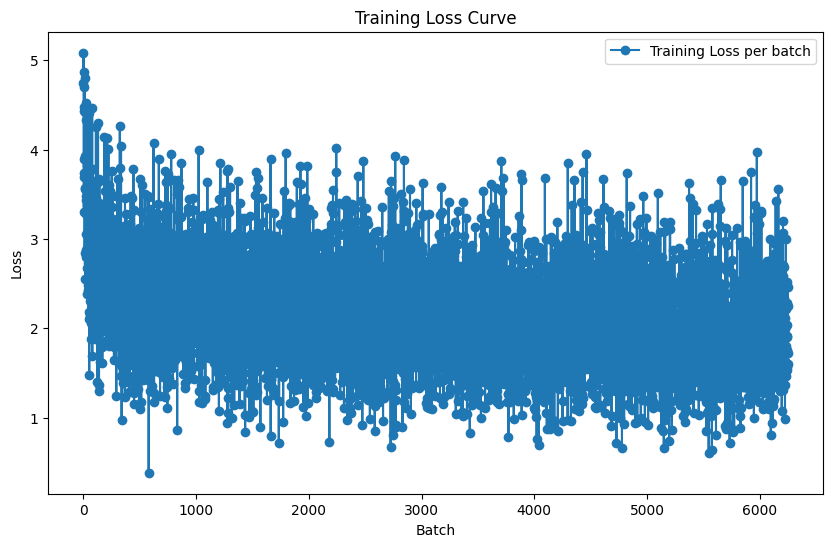

In [24]:
# Plot the learning curve

batchs = range(1, len(training_loss_per_batch) + 1)
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(batchs, training_loss_per_batch, label='Training Loss per batch', marker='o')

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.savefig(f'{plot_path}/batch_training_loss_curve.png')

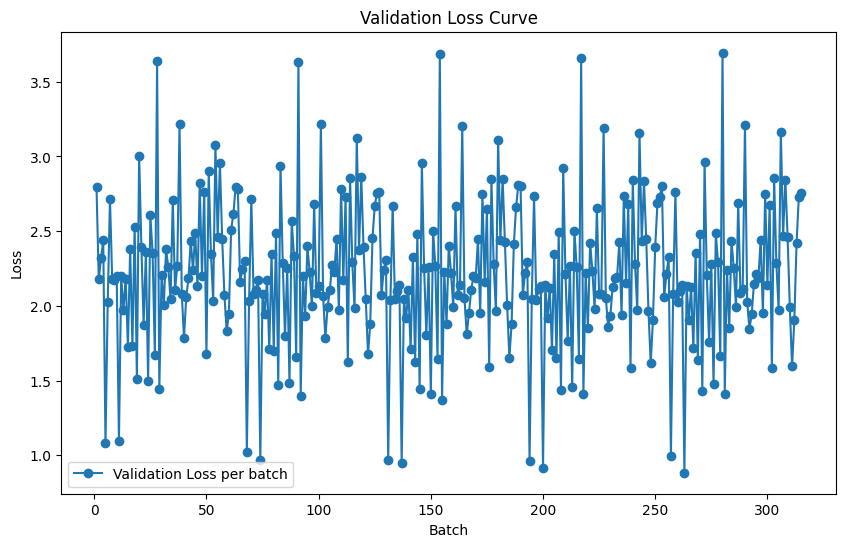

In [25]:
# Plot the learning curve

batchs = range(1, len(validation_loss_per_batch) + 1)
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(batchs, validation_loss_per_batch, label='Validation Loss per batch', marker='o')

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Curve')
plt.savefig(f'{plot_path}/batch_validation_loss_curve.png')

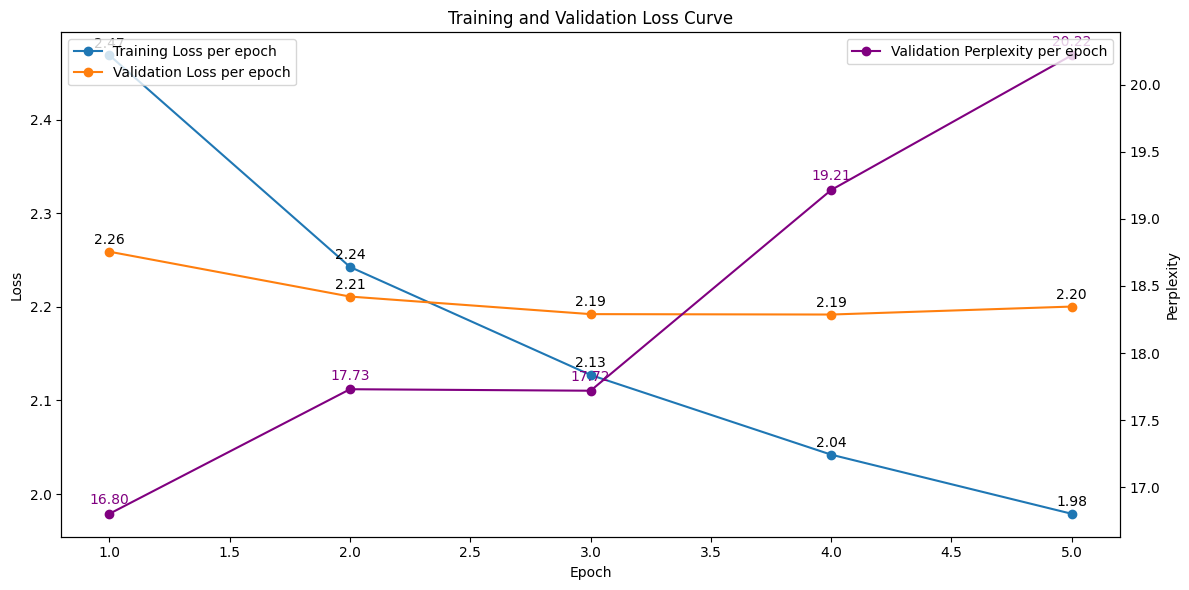

In [29]:
import matplotlib.pyplot as plt

# Plot the learning curves
epochs = range(1, len(training_loss_per_epoch) + 1)
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.plot(epochs, training_loss_per_epoch, label='Training Loss per epoch', marker='o')
plt.plot(epochs, validation_loss_per_epoch, label='Validation Loss per epoch', marker='o')

# Annotate training and validation loss values
for i, value in enumerate(training_loss_per_epoch):
    plt.text(epochs[i], value + 0.005, f'{value:.2f}', ha='center', va='bottom')
for i, value in enumerate(validation_loss_per_epoch):
    plt.text(epochs[i], value + 0.005, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss Curve')

# Add a secondary y-axis for perplexity
ax2 = plt.gca().twinx()
ax2.plot(epochs, validation_perplexity_per_epoch, label='Validation Perplexity per epoch', color='purple', marker='o')

# Annotate validation perplexity values
for i, value in enumerate(validation_perplexity_per_epoch):
    ax2.text(epochs[i], value + 0.05, f'{value:.2f}', ha='center', va='bottom', color='purple')

ax2.set_ylabel('Perplexity')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'{plot_path}/epoch_learning_curve.png')